In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install --quiet scvi-tools[tutorials]==0.9.0a0

if IN_COLAB:
    !pip install --quiet scrublet
    !pip install --quiet --upgrade scikit-learn

In [2]:
!wget https://raw.githubusercontent.com/vinsburg/alluvial_diagram/master/alluvial.py

--2021-03-08 11:54:15--  https://raw.githubusercontent.com/vinsburg/alluvial_diagram/master/alluvial.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11200 (11K) [text/plain]
Saving to: 'alluvial.py.6'

alluvial.py.6       100%[===================>]  10.94K  --.-KB/s    in 0s      

2021-03-08 11:54:15 (44.6 MB/s) - 'alluvial.py.6' saved [11200/11200]



In [3]:
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns

import alluvial
import anndata
import scvi
import scanpy as sc

# sc.set_figure_params(figsize=(4, 4))
if IN_COLAB:
    sc.settings.n_jobs=4
else:
    sc.settings.n_jobs=8
    
N_EPOCHS=250

In [4]:
sns.reset_orig()
sc.settings._vector_friendly = True
# p9.theme_set(p9.theme_classic)
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (4, 4)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = 11
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = 12
plt.rcParams['legend.handlelength'] = 1.4
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 3
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

In [5]:
batch_colors = ["#FDB515", "#870052"]

## Gather data

In [6]:
import gdown
import time
time.sleep(5)
if IN_COLAB:
    !mkdir data
    gdown.download(url="https://drive.google.com/uc?id=1X5N9rOaIqiGxZRyr1fyZ6NpDPeATXoaC", output="data/pbmc_seurat_v4.h5ad", quiet=False)
    gdown.download(url="https://drive.google.com/uc?id=1JgaXNwNeoEqX7zJL-jJD3cfXDGurMrq9", output="data/covid_cite.h5ad", quiet=False)

In [7]:
ref = anndata.read("data/pbmc_seurat_v4.h5ad")
query = anndata.read("data/covid_cite.h5ad")

In [8]:
protein_df = pd.DataFrame(index=ref.obsm["protein_counts"].index)
ref_proteins = ref.obsm["protein_counts"].columns
for p in ref_proteins:
    if p.split("-")[-1] == "1" or p.split("-")[-1] == "2":
        root = p.split("-")[0]
        if root not in ["Notch", "TCR"]:
            try:
                protein_df[root] = (
                    ref.obsm["protein_counts"][root + "-1"]
                    + ref.obsm["protein_counts"][root + "-2"]
                ).values
            except:
                protein_df[p] = ref.obsm["protein_counts"][p]
        else:
            protein_df[p] = ref.obsm["protein_counts"][p]
    else:
        protein_df[p] = ref.obsm["protein_counts"][p]
ref.obsm["protein_counts"] = protein_df

In [9]:
print(ref)
print(query)
query.obsm["protein_counts"] = query.obsm["pro_exp"].copy()
# del query.obsm["pro_exp"]

AnnData object with n_obs × n_vars = 161764 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase'
    obsm: 'protein_counts'
AnnData object with n_obs × n_vars = 57669 × 33538
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code', 'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust', 'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1', 'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og', 'final_clust_withnum', 'final_clust_review', 'Age', 'Gender', 'Gender_num'
    obsm: 'pro_exp'


In [10]:
ref.var['mt'] = ref.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(ref, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

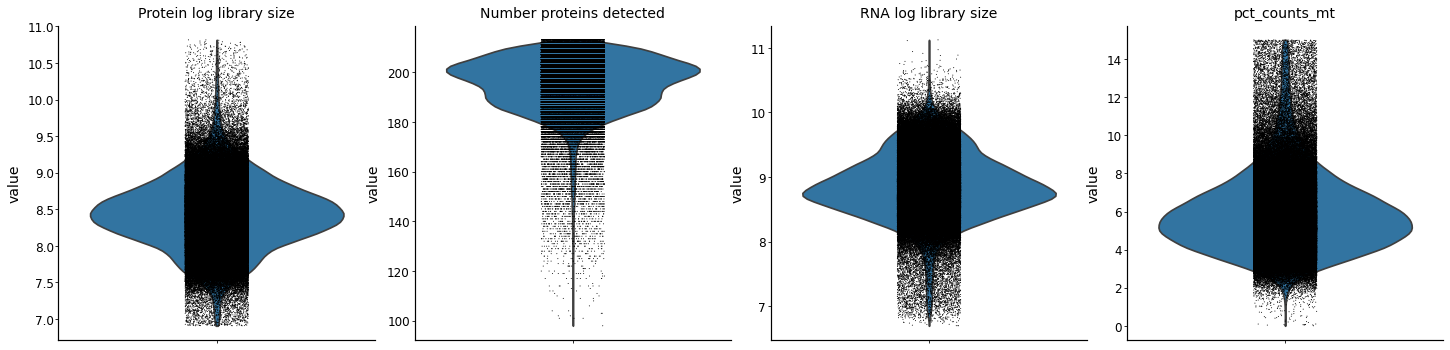

In [11]:
ref.obs["Protein log library size"] = np.log(ref.obsm["protein_counts"].sum(1))
ref.obs["Number proteins detected"] = (ref.obsm["protein_counts"] > 0).sum(1)
ref.obs["RNA log library size"] = np.log(ref.X.sum(1).A)
sc.pl.violin(ref, ["Protein log library size", "Number proteins detected", "RNA log library size", "pct_counts_mt"], multi_panel=True)


In [12]:
ref = ref[ref.obs["Protein log library size"] > 7.6]
ref = ref[ref.obs["Protein log library size"] < 10.3]
ref = ref[ref.obs["Number proteins detected"] > 150]
# filter doublet
ref = ref[ref.obs["celltype.l2"] != "Doublet"]
# MT
ref = ref[ref.obs["pct_counts_mt"] < 12].copy()

In [13]:
# remove isotypes
keep_pros = [not "IgG" in p for p in ref.obsm["protein_counts"].columns]
ref.obsm["protein_counts"] = ref.obsm["protein_counts"].iloc[:, keep_pros].copy()

keep_pros = [not ("Isotype" in p or "Anti" in p) for p in query.obsm["protein_counts"].columns]
query.obsm["protein_counts"] = query.obsm["protein_counts"].iloc[:, keep_pros].copy()

In [14]:
keep_pros = [not ("Isotype" in p or "Anti" in p) for p in query.obsm["protein_counts"].columns]
query.obsm["protein_counts"] = query.obsm["protein_counts"].iloc[:, keep_pros].copy()

In [15]:
sc.pp.highly_variable_genes(
    ref,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="orig.ident",
    subset=True,
)

In [16]:
# randomly pick some proteins to be missing
rand_cats = np.random.permutation(ref.obs["orig.ident"].astype("category").cat.categories)[:5]
for r in rand_cats:
    ref.obsm["protein_counts"][ref.obs["orig.ident"] == r] = 0.0
#     rand_proteins = np.random.permutation(ref.obsm["protein_counts"].columns)[:50]
#     ref.obsm["protein_counts"].loc[ref.obs["orig.ident"] == r, rand_proteins] = 0.0

In [17]:
scvi.data.setup_anndata(
    ref,
    batch_key="orig.ident",
    protein_expression_obsm_key="protein_counts",
)

INFO     Using batches from adata.obs["orig.ident"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_counts']                          
INFO     Using protein names from columns of adata.obsm['protein_counts']                    
INFO     Found batches with missing protein expression                                       
INFO     Successfully registered anndata object containing 151388 cells, 4000 vars, 24       
         batches, 1 labels, and 209 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is t

In [18]:
query = query[:, ref.var_names].copy()
query.obs["celltype.l3"] = "Unknown"
query.obs["celltype.l2"] = "Unknown"
query.obs["orig.ident"] = query.obs["set"]

# reorganize query proteins, missing proteins become all 0
for p in ref.obsm["protein_counts"].columns:
    if p not in query.obsm["protein_counts"].columns:
        query.obsm["protein_counts"][p] = 0.0
query.obsm["protein_counts"] = query.obsm["protein_counts"].loc[:, ref.obsm["protein_counts"].columns]

In [19]:
ref.obs["dataset_name"] = "Reference"
query.obs["dataset_name"] = "Query"

## TotalVI + scArches

In [20]:
def classify_from_latent(
    ref: sc.AnnData, 
    query: sc.AnnData, 
    ref_obsm_key: str = "X_totalvi_scarches", 
    labels_obs_key: str = "celltype.l2",
    classifier: str = "random_forest",
):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier

    y_train = ref.obs[labels_obs_key].astype("category").cat.codes.to_numpy()
    X_train = ref.obsm[ref_obsm_key]
    if classifier == "random_forest":
        clf = RandomForestClassifier(
            random_state=1, 
            class_weight = "balanced_subsample",
            verbose=1,
            n_jobs=-1,
        )
    else:
        clf = MLPClassifier(
            hidden_layer_sizes=(128, 64, 32,), 
            random_state=1, 
            max_iter=300, 
            verbose=True, 
            early_stopping=True, 
            learning_rate_init=1e-3
        )
    clf.fit(X_train, y_train)
    predictions = clf.predict(query.obsm[ref_obsm_key])
    categories = ref.obs[labels_obs_key].astype("category").cat.categories
    cat_preds = [categories[i] for i in predictions]
    
    return cat_preds

In [21]:
def run_totalvi_scarches(ref, query):
    """Run online totalVI."""

    # initialize and train model
    arches_params = dict(
        use_layer_norm="both",
        use_batch_norm="none",
        n_layers_decoder=2,
        n_layers_encoder=2,
    )

    start = time.time()
    vae = scvi.model.TOTALVI(
        ref, 
        **arches_params
    )
    vae.train(max_epochs=N_EPOCHS, batch_size=256, lr=4e-3)
    end = time.time()
    print("\n Total reference train time: {}".format(end-start))

    plt.plot(vae.history["elbo_validation"][10:], label="validation")
    plt.title("Negative ELBO over training epochs")
    plt.legend()

    ref.obsm["X_totalvi_scarches"] = vae.get_latent_representation()

    start = time.time()
    vae_q = scvi.model.TOTALVI.load_query_data(
        query, 
        vae,
    )

    vae_q.train(
        150, 
        lr=4e-3, 
        batch_size=256, 
        plan_kwargs=dict(
            weight_decay=0.0,
            scale_adversarial_loss=0.0
        ),
        # n_steps_kl_warmup=1,
    )
    end = time.time()
    print("\n Total query train time: {}".format(end-start))

    query.obsm["X_totalvi_scarches"] = vae_q.get_latent_representation(query)

    # predict cell types of query
    query.obs["predicted_l2_scarches"] = classify_from_latent(ref, query, ref_obsm_key="X_totalvi_scarches")
    query.obs["celltype.l2"] = query.obs["predicted_l2_scarches"]

    adata_full_new = anndata.concat([ref, query])
    adata_full_new.uns["_scvi"] = query.uns["_scvi"].copy()
    adata_full_new.obsm["X_totalvi_scarches"] = vae_q.get_latent_representation(adata_full_new)

    print("Computing full umap")
    sc.pp.neighbors(adata_full_new, use_rep="X_totalvi_scarches", metric="cosine")
    sc.tl.umap(adata_full_new, min_dist=0.3)

    return vae, vae_q, adata_full_new

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 250/250: 100%|██████████| 250/250 [1:01:23<00:00, 14.73s/it, loss=634, v_num=1]

 Total reference train time: 3690.838667869568
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Found batches with missing protein expression                                       
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'protein_expression']                                                               
INFO     Successfully registered anndata object containing 57669 cells, 4000 vars, 26        
         batches, 1 labels, and 209 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  


/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 150/150: 100%|██████████| 150/150 [19:39<00:00,  7.86s/it, loss=491, v_num=1] 

 Total query train time: 1180.0636043548584


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


Computing full umap


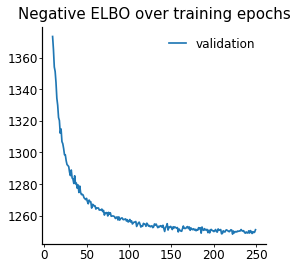

In [22]:
vae_arches, vae_q_arches, full_data_arches = run_totalvi_scarches(ref, query)

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
... storing 'orig.ident' as categorical
... storing 'celltype.l2' as categorical
... storing 'celltype.l3' as categorical
... storing 'dataset_name' as categorical


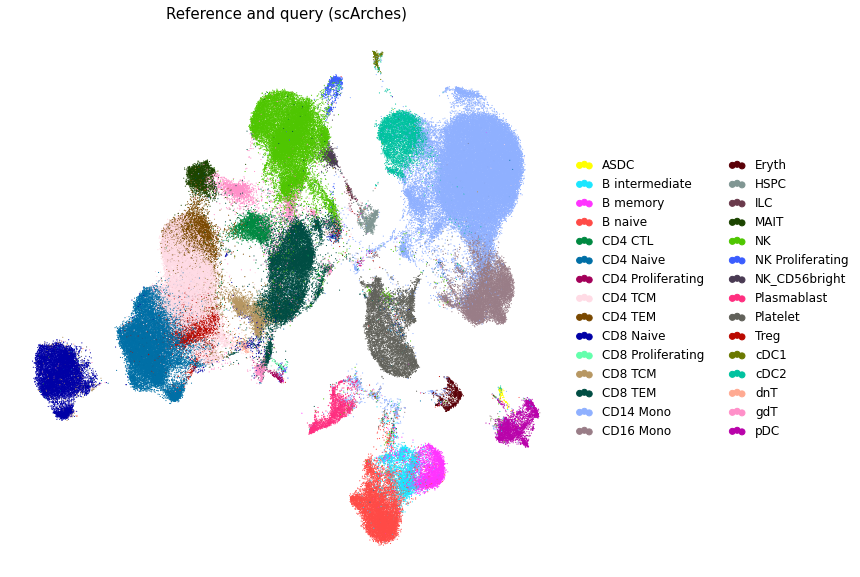

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.umap(
    full_data_arches,
    color=["celltype.l2"],
    frameon=False,
    ncols=1,
    title="Reference and query (scArches)",
    ax=ax,
    size=5,
)

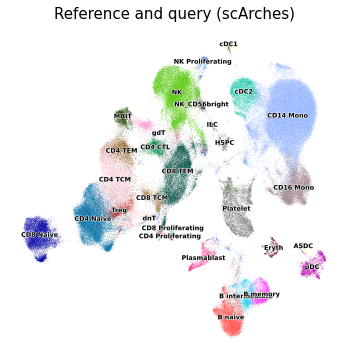

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    full_data_arches,
    color=["celltype.l2"],
    frameon=False,
    ncols=1,
    title="Reference and query (scArches)",
    legend_loc="on data",
    legend_fontsize="xx-small",
    legend_fontoutline=1,
    ax=ax,
#     size=5,
)
fig.savefig("figs/scarches_ref_query_by_cell_type.pdf", bbox_inches="tight", dpi=DPI)

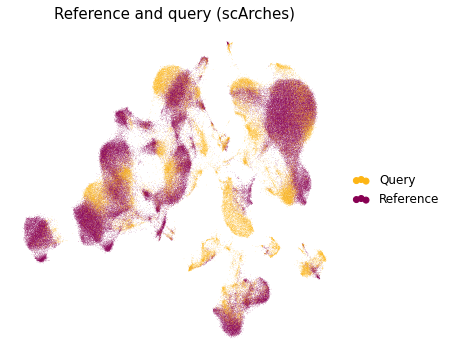

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    full_data_arches,
    color=["dataset_name"],
    frameon=False,
    ncols=1,
    title="Reference and query (scArches)",
    palette=batch_colors,
    ax=ax,
#     size=5,
)
fig.savefig("figs/scarches_ref_query.pdf", bbox_inches="tight", dpi=DPI)

## TotalVI default

In [26]:
def run_totalvi_default(ref, query):
    """Run 'offline' totalVI."""

    adata_full_new = anndata.concat([ref, query])
    scvi.data.setup_anndata(
        adata_full_new,
        batch_key="orig.ident",
        protein_expression_obsm_key="protein_counts",
    )

    # initialize and train model
    arches_params = dict(
        use_layer_norm="both",
        use_batch_norm="none",
        n_layers_decoder=2,
        n_layers_encoder=2,
    )

    start = time.time()
    vae = scvi.model.TOTALVI(
        adata_full_new, 
        **arches_params
    )
    vae.train(max_epochs=N_EPOCHS, batch_size=256, lr=4e-3)
    end = time.time()
    print("\n Total default train time: {}".format(end-start))

    adata_full_new.obsm["X_totalvi_default"] = vae.get_latent_representation()


    plt.plot(vae.history["elbo_validation"][10:], label="validation")
    plt.title("Negative ELBO over training epochs")
    plt.legend()

    ref.obsm["X_totalvi_default"] = vae.get_latent_representation(ref)
    query.obsm["X_totalvi_default"] = vae.get_latent_representation(query)

    # predict cell types of query
    query.obs["predicted_l2_default"] = classify_from_latent(ref, query, ref_obsm_key="X_totalvi_default")


    query.obs["celltype.l2"] = query.obs["predicted_l2_default"]

    print("Computing full umap")
    sc.pp.neighbors(adata_full_new, use_rep="X_totalvi_default", metric="cosine")
    sc.tl.umap(adata_full_new, min_dist=0.3)

    return vae, adata_full_new

INFO     Using batches from adata.obs["orig.ident"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_counts']                          
INFO     Using protein names from columns of adata.obsm['protein_counts']                    
INFO     Found batches with missing protein expression                                       
INFO     Successfully registered anndata object containing 209057 cells, 4000 vars, 26       
         batches, 1 labels, and 209 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is t

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 250/250: 100%|██████████| 250/250 [1:19:31<00:00, 19.09s/it, loss=568, v_num=1]

 Total default train time: 4777.495653390884
WARNING  Categorical encoding for batch is similar but not equal between the anndata used to 
         train and the anndata passed in. Will attempt transfer. Expected categories: ['P1_0'
         'P1_3' 'P1_7' 'P2_0' 'P2_3' 'P2_7' 'P3_0' 'P3_3' 'P3_7' 'P4_0'                      
          'P4_3' 'P4_7' 'P5_0' 'P5_3' 'P5_7' 'P6_0' 'P6_3' 'P6_7' 'P7_0' 'P7_3'              
          'P7_7' 'P8_0' 'P8_3' 'P8_7' 'set1' 'set2']. Received categories: ['P1_0' 'P1_3'    
         'P1_7' 'P2_0' 'P2_3' 'P2_7' 'P3_0' 'P3_3' 'P3_7' 'P4_0'                             
          'P4_3' 'P4_7' 'P5_0' 'P5_3' 'P5_7' 'P6_0' 'P6_3' 'P6_7' 'P7_0' 'P7_3'              
          'P7_7' 'P8_0' 'P8_3' 'P8_7'].                                                      
                                                                                             
INFO     Found batches

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` para

Computing full umap


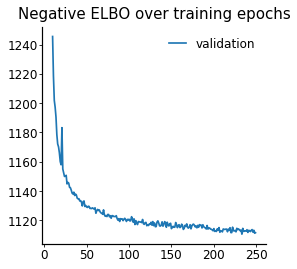

In [27]:
vae_default, full_data_default = run_totalvi_default(ref, query)

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
... storing 'orig.ident' as categorical
... storing 'celltype.l2' as categorical
... storing 'celltype.l3' as categorical
... storing 'dataset_name' as categorical


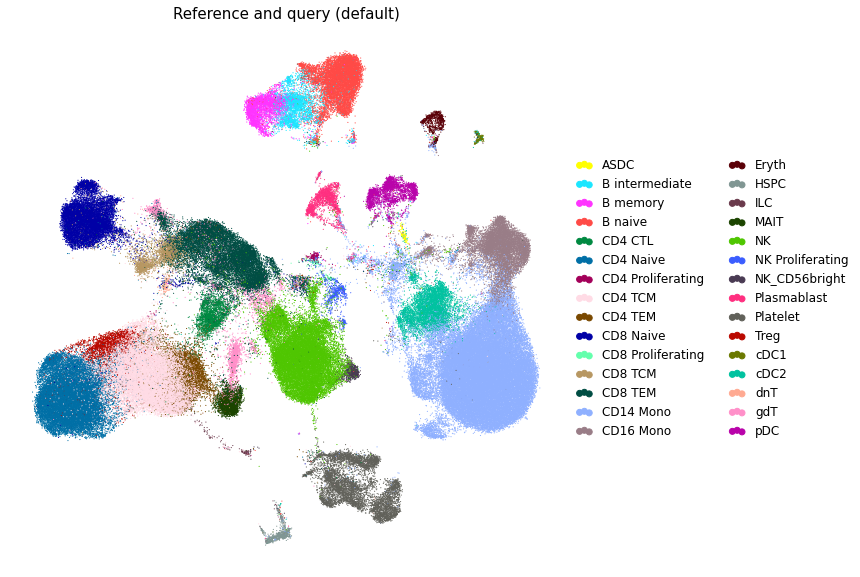

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.umap(
    full_data_default,
    color=["celltype.l2"],
    frameon=False,
    ncols=1,
    title="Reference and query (default)",
    ax=ax,
    size=5,
)

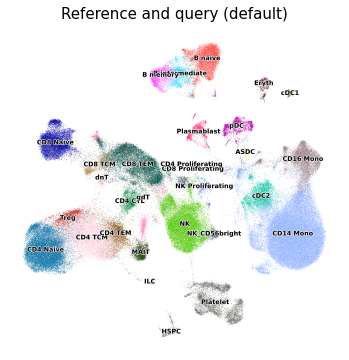

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    full_data_default,
    color=["celltype.l2"],
    frameon=False,
    ncols=1,
    title="Reference and query (default)",
    legend_loc="on data",
    legend_fontsize="xx-small",
    legend_fontoutline=1,
    ax=ax,
)
fig.savefig("figs/default_ref_query_by_cell_type.pdf", bbox_inches="tight", dpi=DPI)

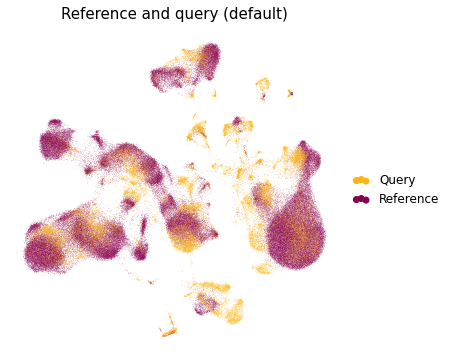

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    full_data_default,
    color=["dataset_name"],
    frameon=False,
    ncols=1,
    palette=batch_colors,
    title="Reference and query (default)",
    ax=ax,
#     size=5,
)
fig.savefig("figs/default_ref_query.pdf", bbox_inches="tight", dpi=DPI)

In [31]:
query.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4',
       'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code',
       'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust',
       'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1',
       'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og',
       'final_clust_withnum', 'final_clust_review', 'Age', 'Gender',
       'Gender_num', 'celltype.l3', 'celltype.l2', 'dataset_name',
       '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean',
       '_scvi_local_l_var', 'predicted_l2_scarches', 'predicted_l2_default'],
      dtype='object')

## Query specific analysis

In [32]:
sc.pp.neighbors(query, use_rep="X_totalvi_scarches")
sc.tl.umap(query)

In [33]:
# vae_q
df = vae_default.get_protein_foreground_probability(query, n_samples=10)

for c in df.columns:
    query.obs[c + "_prob_fg"] = df[c]

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
print(np.sort(df.columns.tolist()))

['B7-H4' 'C5L2' 'CCR10' 'CD102' 'CD103' 'CD105' 'CD106' 'CD107a' 'CD109'
 'CD110' 'CD112' 'CD115' 'CD117' 'CD119' 'CD11a/CD18' 'CD11b' 'CD11c'
 'CD122' 'CD123' 'CD124' 'CD126' 'CD127' 'CD13' 'CD133' 'CD134' 'CD135'
 'CD137' 'CD138' 'CD14' 'CD140a' 'CD140b' 'CD141' 'CD142' 'CD144' 'CD146'
 'CD15' 'CD152' 'CD154' 'CD155' 'CD16' 'CD161' 'CD163' 'CD164' 'CD169'
 'CD171' 'CD172a' 'CD177' 'CD178' 'CD18' 'CD184' 'CD185' 'CD186' 'CD19'
 'CD192' 'CD193' 'CD194' 'CD195' 'CD196' 'CD199' 'CD1a' 'CD1c' 'CD1d'
 'CD2' 'CD20' 'CD200' 'CD201' 'CD202b' 'CD203c' 'CD204' 'CD205' 'CD206'
 'CD207' 'CD209' 'CD21' 'CD22' 'CD223' 'CD226' 'CD235a' 'CD235ab' 'CD24'
 'CD243' 'CD244' 'CD25' 'CD252' 'CD253' 'CD26' 'CD267' 'CD268' 'CD269'
 'CD27' 'CD270' 'CD271' 'CD272' 'CD273' 'CD274' 'CD275' 'CD278' 'CD279'
 'CD28' 'CD284' 'CD29' 'CD294' 'CD3' 'CD30' 'CD301' 'CD303' 'CD304'
 'CD305' 'CD307c/FcRL3' 'CD307d' 'CD307e' 'CD309' 'CD31' 'CD314' 'CD319'
 'CD324' 'CD325' 'CD335' 'CD337' 'CD338' 'CD34' 'CD340' 'CD35' 'CD354

In [35]:
query.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4',
       'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code',
       'covidpt_orhealth',
       ...
       'CD16_prob_fg', 'CD161_prob_fg', 'CCR10_prob_fg', 'CD271_prob_fg',
       'GP130_prob_fg', 'CD199_prob_fg', 'CD45RB_prob_fg', 'CD46_prob_fg',
       'VEGFR-3_prob_fg', 'CLEC2_prob_fg'],
      dtype='object', length=248)

In [36]:
query_pro_df = query.obsm["pro_exp"]
query_pro_df.columns

Index(['CD3', 'CD4', 'CD8', 'CD19', 'CD20', 'CD56', 'CD69', 'CD28', 'CD95',
       'CD279-PD', 'CD197', 'CD45RO', 'CD45RA', 'HLA', 'CD14', 'CD16', 'CD11c',
       'CD1c-BDCA1', 'CD370-CLEC9A', 'CD123', 'CD86', 'CD274-PD', 'CD163',
       'CD33', 'CD57', 'CD27', 'CD38', 'CD25', 'CD34', 'TCRgd', 'TCRa7',
       'Anti', 'CD127', 'CD94', 'FCER1a', 'Isotype1', 'Isotype2', 'Isotype3',
       'Isotype4'],
      dtype='object')

(array([4.3520e+03, 1.5323e+04, 1.8297e+04, 1.3225e+04, 4.4070e+03,
        1.3890e+03, 3.3700e+02, 1.3100e+02, 7.6000e+01, 6.3000e+01,
        2.3000e+01, 2.1000e+01, 8.0000e+00, 7.0000e+00, 3.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 0.        ,  0.62612474,  1.2522495 ,  1.8783743 ,  2.504499  ,
         3.1306238 ,  3.7567487 ,  4.3828735 ,  5.008998  ,  5.635123  ,
         6.2612476 ,  6.8873725 ,  7.5134974 ,  8.139622  ,  8.765747  ,
         9.391871  , 10.017996  , 10.644121  , 11.270246  , 11.896371  ,
        12.522495  ], dtype=float32),
 <BarContainer object of 20 artists>)

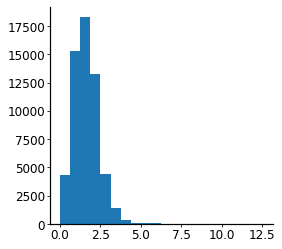

In [37]:
plt.hist(np.log1p(query_pro_df["CD19"]), bins=20)

... storing 'celltype.l3' as categorical
... storing 'celltype.l2' as categorical
... storing 'dataset_name' as categorical
... storing 'predicted_l2_scarches' as categorical
... storing 'predicted_l2_default' as categorical


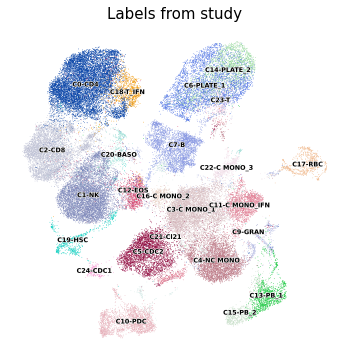

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    query,
    color=["final_clust_review"],
    ncols=1,
    frameon=False,
    legend_loc="on data",
    legend_fontsize="xx-small",
    legend_fontoutline=1,
    title="Labels from study",
    ax=ax,
)
fig.savefig("figs/query_truth_umap.pdf", bbox_inches="tight", dpi=DPI)

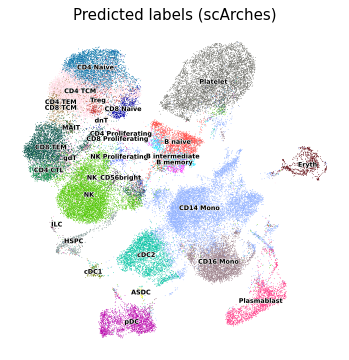

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    query,
    color=["predicted_l2_scarches"],
    ncols=1,
    frameon=False,
    legend_loc="on data",
    legend_fontsize="xx-small",
    legend_fontoutline=1,
    title="Predicted labels (scArches)",
    ax=ax,
)
fig.savefig("figs/query_arches_umap.pdf", bbox_inches="tight", dpi=DPI)

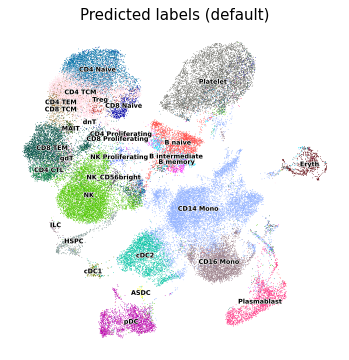

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    query,
    color=["predicted_l2_default"],
    ncols=1,
    frameon=False,
    legend_loc="on data",
    legend_fontsize="xx-small",
    legend_fontoutline=1,
    title="Predicted labels (default)",
    ax=ax,
)
fig.savefig("figs/query_default_umap.pdf", bbox_inches="tight", dpi=DPI)

## Plotting

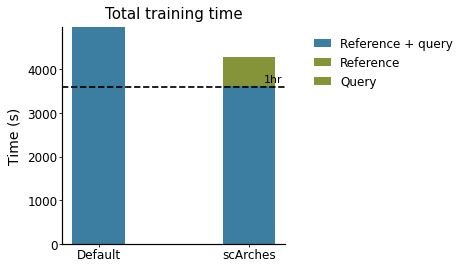

In [41]:
N = 2
default_times = [4982, 3624]
arches_times = [0, 666]

ind = np.arange(N)  # the x locations for the groups
width = 0.35  # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, default_times, width, color="#3B7EA1")
p2 = plt.bar(ind, arches_times, width, bottom=default_times, color="#859438")
# p2[0].set_color("blue")
# # p2[1].set_color("red")

plt.ylabel("Time (s)")
plt.title("Total training time")
plt.xticks(ind, ("Default", "scArches"))
plt.legend(
    (p1[0], p2[0], p2[1]),
    ("Reference + query", "Reference", "Query"),
    loc="upper right",
    bbox_to_anchor=(1.3, 0.5, 0.5, 0.5),
)
plt.axhline(3600, c="black", linestyle="--")
plt.text(1.1, 3700, "1hr")

plt.savefig("figs/time.pdf", bbox_inches="tight")

In [42]:
from matplotlib.colors import ListedColormap

colors = full_data_default.uns["celltype.l2_colors"]
ctype_cmap = ListedColormap(colors)

# color order using value counts
color_order = np.argsort(
    query.obs["predicted_l2_scarches"]
    .value_counts()
    .loc[full_data_default.obs["celltype.l2"].cat.categories]
)

In [43]:
a_order = [
    "B intermediate",
    "B naive",
    "B memory",
    "CD14 Mono",
    "CD16 Mono",
    "cDC1",
    "cDC2",
    "pDC",
    "CD4 Naive",
    "CD4 TCM",
    "CD4 TEM",
    "CD4 Proliferating",
    "Treg",
    "CD4 CTL",
    "CD8 Naive",
    "CD8 TCM",
    "CD8 TEM",
    "CD8 Proliferating",
    "dnT",
    "MAIT",
    "gdT",
    "NK",
    "NK Proliferating",
    "NK_CD56bright",
    "Platelet",
    "Plasmablast",
    "HSPC",
    "ILC",
    "ASDC",
    "Eryth",
]
b_order = [
    "C7-B",
    "C3-C MONO_1",
    "C16-C MONO_2",
    "C22-C MONO_3",
    "C11-C MONO_IFN",
    "C9-GRAN",
    "C4-NC MONO",
    "C24-CDC1",
    "C5-CDC2",
    "C10-PDC",
    "C0-CD4",
    "C18-T_IFN",
    "C2-CD8",
    "C23-T",
    "C20-BASO",
    "C1-NK",
    "C6-PLATE_1",
    "C14-PLATE_2",
    "C13-PB_1",
    "C15-PB_2",
    "C19-HSC",
    "C21-Cl21",
    "C17-RBC",
]
# manual color order
cats = full_data_default.obs["celltype.l2"].cat.categories
color_order = pd.Series(np.arange(len(cats)), index=cats)
color_order = color_order.loc[a_order].values[::-1]

/home/adam/Documents/scvi-tools-reproducibility/alluvial.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(alluvial_fan)


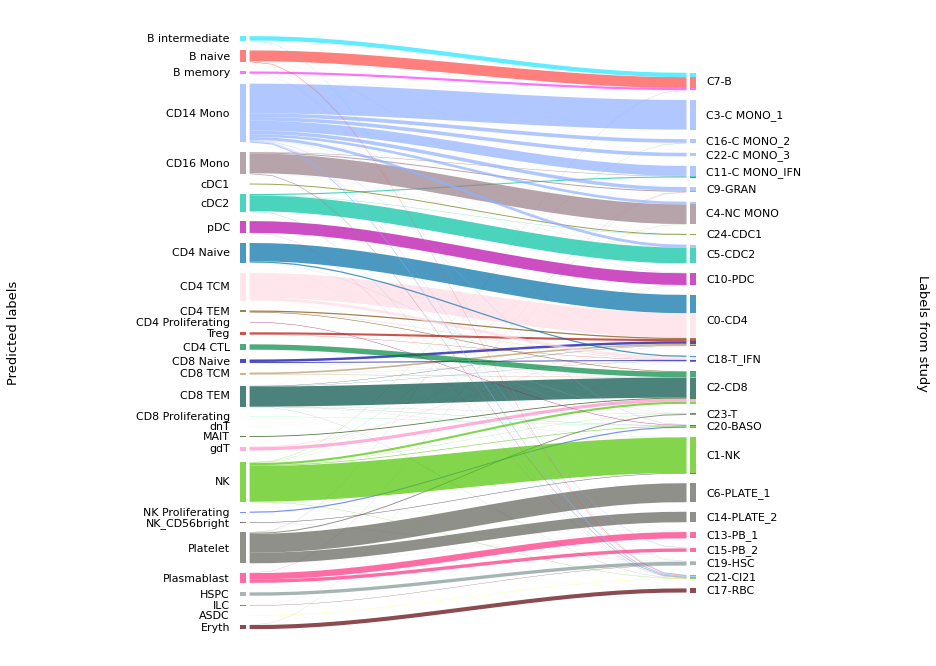

In [44]:
input_data = query.obs[["predicted_l2_scarches", "final_clust_review"]].values.tolist()

ax = alluvial.plot(
    input_data,
    alpha=0.7,
    color_side=0,
    rand_seed=1,
    figsize=(9, 12),
#     disp_width=True,
    wdisp_sep=" " * 2,
    colors=np.array(colors)[color_order],
    fontname="Dejavu Sans",
    labels=("Predicted labels", "Labels from study"),
    label_shift=1,
    a_sort=a_order[::-1],
    b_sort=b_order[::-1]
)
# ax.set_title('Utility display', fontsize=14, fontname='Dejavu Sans')
fig = plt.gcf()
fig.savefig("figs/alluvial.pdf", dpi=DPI, bbox_inches="tight")
fig.savefig("figs/alluvial.png", dpi=DPI, bbox_inches="tight")
plt.show()


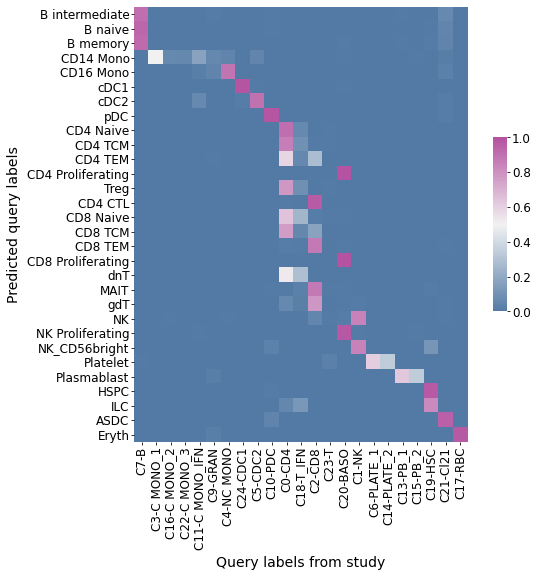

In [45]:
df = query.obs
confusion_matrix = pd.crosstab(
    df["predicted_l2_scarches"],
    df["final_clust_review"],
    rownames=["Predicted query labels"],
    colnames=["Query labels from study"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
confusion_matrix = confusion_matrix.loc[a_order, b_order]
fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(
    confusion_matrix,
    cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.4, aspect=12),
)
fig.savefig("figs/confusion_matrix_scarches_study.pdf", dpi=DPI, bbox_inches="tight")

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


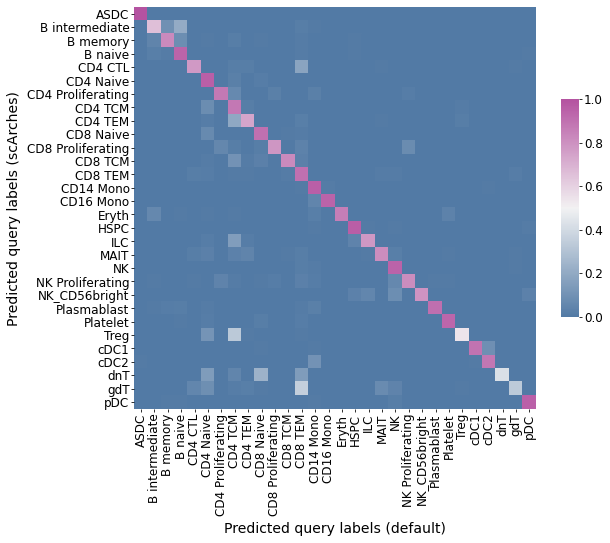

In [46]:
df = query.obs
confusion_matrix = pd.crosstab(
    df["predicted_l2_default"],
    df["predicted_l2_scarches"],
    rownames=["Predicted query labels (default)"],
    colnames=["Predicted query labels (scArches)"],
)
confusion_matrix /= confusion_matrix.sum(0)
fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(
    confusion_matrix.transpose(),
    ax=ax,
    square=True,
    cbar_kws=dict(shrink=0.5, aspect=12),
    cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
)
fig.savefig("figs/confusion_matrix.pdf", dpi=DPI, bbox_inches="tight")

In [47]:
query.obs.columns

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4',
       'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code',
       'covidpt_orhealth',
       ...
       'CD16_prob_fg', 'CD161_prob_fg', 'CCR10_prob_fg', 'CD271_prob_fg',
       'GP130_prob_fg', 'CD199_prob_fg', 'CD45RB_prob_fg', 'CD46_prob_fg',
       'VEGFR-3_prob_fg', 'CLEC2_prob_fg'],
      dtype='object', length=248)

In [48]:
df = query.obs[["predicted_l2_scarches", "Resp", "subj_code", "Age"]]
plot_df = pd.DataFrame()

for state in np.unique(df["Resp"]):
    temp_df = df.loc[df["Resp"] == state]
    for patient in np.unique(temp_df["subj_code"]):
        temp_df2 = temp_df.loc[temp_df["subj_code"] == patient]
        n_cells = len(temp_df2)
        for ct in np.unique(temp_df2["predicted_l2_scarches"]):
            n_ct = np.sum(temp_df2["predicted_l2_scarches"] == ct)
            plot_df.loc[patient, "{} frequency".format(ct)] = n_ct / n_cells
        plot_df.loc[patient, "COVID status"] = state
        plot_df.loc[patient, "Age"] = temp_df2["Age"].values[0]

In [49]:
mait_df = vae_q_arches.differential_expression(query, groupby="predicted_l2_scarches", group1="MAIT", group2="CD8 TEM")
mait_df.iloc[:15]

DE...: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
RBM24,0.9976,0.0024,6.029880,0.000011,3.942868e-07,5.551382,5.602739,1.967614,-1.398970,11.726705,0.028249,0.000241,0.022599,0.000241,0.277371,0.001679,True,MAIT vs CD8 TEM
SLC4A10,0.9970,0.0030,5.806135,0.000298,7.579994e-06,6.113564,6.305190,1.989559,-1.591265,11.359505,0.757062,0.005537,0.491525,0.005055,9.885355,0.057484,True,MAIT vs CD8 TEM
CCR6,0.9966,0.0034,5.680571,0.000198,1.401781e-05,4.459183,4.666818,1.670283,-2.690990,8.578453,0.175141,0.008666,0.152542,0.006259,2.235722,0.080150,True,MAIT vs CD8 TEM
ROR2,0.9962,0.0038,5.568944,0.000016,9.300061e-07,4.739451,4.815600,1.795550,-1.147665,10.354552,0.016949,0.000963,0.011299,0.000722,0.207127,0.007595,True,MAIT vs CD8 TEM
COL5A1,0.9954,0.0046,5.377086,0.000004,2.587433e-07,4.603168,4.713964,1.775428,-3.072927,10.039638,0.016949,0.000000,0.016949,0.000000,0.217162,0.000000,True,MAIT vs CD8 TEM
AC010967.1,0.9952,0.0048,5.334326,0.000004,2.086700e-07,4.953285,4.996504,2.003147,-1.696754,10.737343,0.011299,0.000000,0.011299,0.000000,0.106767,0.000000,True,MAIT vs CD8 TEM
PRSS35,0.9950,0.0050,5.293303,0.000042,1.156975e-06,6.226876,6.404842,2.316465,-1.929663,12.875092,0.112994,0.001685,0.090395,0.001444,1.571327,0.017283,True,MAIT vs CD8 TEM
LINGO4,0.9932,0.0068,4.984008,0.000004,2.260003e-07,4.479284,4.508169,1.861960,-3.241100,12.012268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True,MAIT vs CD8 TEM
CDH2,0.9932,0.0068,4.984008,0.000007,5.234388e-07,3.992993,4.063137,1.627120,-2.388535,10.018121,0.005650,0.000000,0.005650,0.000000,0.063911,0.000000,True,MAIT vs CD8 TEM
KIT,0.9926,0.0074,4.898846,0.000013,7.990025e-07,4.587759,4.683703,1.984813,-5.211803,11.001823,0.005650,0.000481,0.005650,0.000241,0.078577,0.006497,True,MAIT vs CD8 TEM


In [50]:
cd4_ctl_df = vae_q_arches.differential_expression(query, groupby="predicted_l2_scarches", group1="CD4 CTL", group2="CD4 Naive")
cd4_ctl_df.iloc[:15]

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DE...: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
AEBP1,1.0,0.0,18.420681,1.626292e-06,5.702613e-05,-5.204629,-5.253497,0.851601,-7.954252,-0.371775,0.001996,0.029516,0.001996,0.029243,0.024051,0.583490,True,CD4 CTL vs CD4 Naive
AC069222.1,1.0,0.0,18.420681,7.523375e-08,1.976680e-06,-4.812788,-4.838242,1.182171,-8.689501,-0.446484,0.000000,0.002186,0.000000,0.002186,0.000000,0.046440,True,CD4 CTL vs CD4 Naive
MAL,1.0,0.0,18.420681,6.279723e-05,2.124688e-03,-5.199523,-5.292550,0.927632,-7.760923,1.950349,0.064870,1.112321,0.037924,0.608910,0.453481,21.325392,True,CD4 CTL vs CD4 Naive
PTMS,1.0,0.0,18.420681,3.075394e-04,2.690802e-05,3.553799,3.585874,0.727724,0.505249,5.877078,0.197605,0.011479,0.151697,0.009292,2.085774,0.173668,True,CD4 CTL vs CD4 Naive
ADTRP,1.0,0.0,18.420681,1.292381e-05,1.157649e-03,-6.439415,-6.480829,1.419325,-11.208048,-0.451822,0.016966,0.497674,0.012974,0.345176,0.123236,9.912279,True,CD4 CTL vs CD4 Naive
KLRG1,1.0,0.0,18.420681,1.545302e-03,1.234926e-04,3.688148,3.722806,0.675194,0.526467,6.724319,1.526950,0.078437,0.733533,0.068051,17.228479,1.397723,True,CD4 CTL vs CD4 Naive
KLRD1,1.0,0.0,18.420681,1.278939e-03,4.436409e-05,4.914159,4.982035,1.031754,0.697249,7.912104,0.384231,0.012845,0.174651,0.012572,4.275480,0.245935,True,CD4 CTL vs CD4 Naive
TRGV7,1.0,0.0,18.420681,2.195275e-05,9.264661e-07,4.752961,4.803166,1.129283,-0.754251,8.347818,0.052894,0.000547,0.037924,0.000273,0.665861,0.014615,True,CD4 CTL vs CD4 Naive
CCL4,1.0,0.0,18.420681,2.166847e-03,9.999621e-05,4.440721,4.479999,0.777368,1.003967,6.992807,3.097814,0.033616,0.656687,0.033069,33.729965,0.670336,True,CD4 CTL vs CD4 Naive
LGMN,1.0,0.0,18.420681,5.774579e-06,6.694920e-05,-3.565715,-3.585203,0.636415,-5.722233,-0.710344,0.003992,0.035256,0.003992,0.033889,0.020813,0.635431,True,CD4 CTL vs CD4 Naive


/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


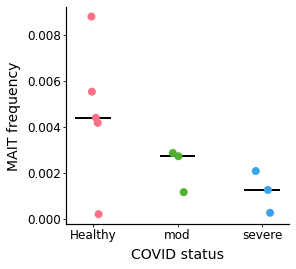

In [51]:
def stripplot_freq(plot_df, y):

    ax = sns.stripplot(x="COVID status", y=y, data=plot_df, s=8, palette=sns.color_palette("husl", 3))

    # distance across the "X" or "Y" stipplot column to span, in this case 40%
    median_width = 0.4
    for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
        sample_name = text.get_text()  # "X" or "Y"

        # calculate the median value for all replicates of either X or Y
        median_val = plot_df[plot_df['COVID status']==sample_name][y].median()

        # plot horizontal lines across the column, centered on the tick
        ax.plot([tick-median_width/2, tick+median_width/2], [median_val, median_val],
                lw=2, color='k')
        
    return ax
        
ax = stripplot_freq(plot_df, "MAIT frequency")
fig = plt.gcf()
fig.savefig("figs/mait_frequency.pdf", dpi=DPI, bbox_inches="tight")

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


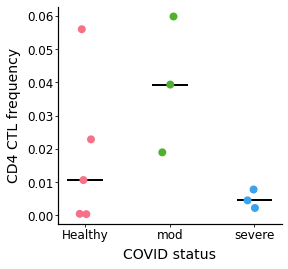

In [52]:
stripplot_freq(plot_df, "CD4 CTL frequency")
fig = plt.gcf()
fig.savefig("figs/cd4_ctl_frequency.pdf", dpi=DPI, bbox_inches="tight")

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='COVID status', ylabel='CD4 Naive frequency'>

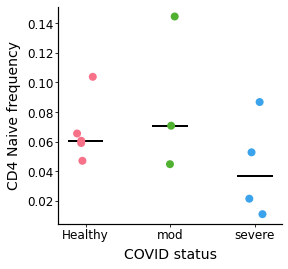

In [53]:
stripplot_freq(plot_df, "CD4 Naive frequency")

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='COVID status', ylabel='CD8 TEM frequency'>

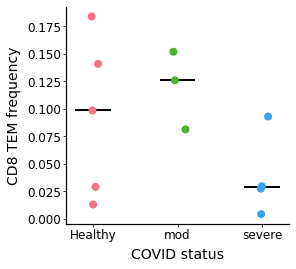

In [54]:
stripplot_freq(plot_df, "CD8 TEM frequency")

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='COVID status', ylabel='Plasmablast frequency'>

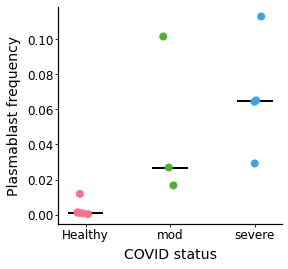

In [55]:
stripplot_freq(plot_df, "Plasmablast frequency")

### Dotplots

In [56]:
query_dot = query.copy()

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
sc.pp.normalize_total(query_dot)
sc.pp.log1p(query_dot)

In [58]:
mait_df = mait_df.loc[mait_df["non_zeros_proportion1"] > 0.1]
mait_df = mait_df.loc[mait_df["bayes_factor"] > 3]
mait_df = mait_df.sort_values(by="lfc_mean", ascending=False)

cd4_ctl_df = cd4_ctl_df.loc[cd4_ctl_df["non_zeros_proportion1"] > 0.1]
cd4_ctl_df = cd4_ctl_df.loc[cd4_ctl_df["bayes_factor"] > 3]
cd4_ctl_df = cd4_ctl_df.sort_values(by="lfc_mean", ascending=False)


In [59]:
# drop proteins, have NA column
mait_df = mait_df.dropna()
cd4_ctl_df = cd4_ctl_df.dropna()

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
mait_df

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
SLC4A10,0.9970,0.0030,5.806135,0.000298,0.000008,6.113564,6.305190,1.989559,-1.591265,11.359505,0.757062,0.005537,0.491525,0.005055,9.885355,0.057484,True,MAIT vs CD8 TEM
CCR6,0.9966,0.0034,5.680571,0.000198,0.000014,4.459183,4.666818,1.670283,-2.690990,8.578453,0.175141,0.008666,0.152542,0.006259,2.235722,0.080150,True,MAIT vs CD8 TEM
AQP3,0.9870,0.0130,4.329720,0.001188,0.000172,3.215881,3.395174,1.285300,-1.842609,6.301473,0.949153,0.126865,0.559322,0.093404,12.480024,1.169857,True,MAIT vs CD8 TEM
CCR2,0.9828,0.0172,4.045496,0.000100,0.000016,2.843400,2.902615,1.259047,-2.657289,6.372045,0.146893,0.008185,0.135593,0.007944,1.821908,0.102337,True,MAIT vs CD8 TEM
KLRB1,0.9838,0.0162,4.106411,0.006118,0.000894,2.836352,2.923689,1.271692,-3.711950,7.174320,9.367232,0.986280,0.932203,0.298507,122.995705,9.692658,True,MAIT vs CD8 TEM
MYC,0.9826,0.0174,4.033731,0.000451,0.000083,2.723086,2.880937,1.174902,-2.331848,5.536233,0.468926,0.087867,0.299435,0.064998,5.633996,0.848899,True,MAIT vs CD8 TEM
BLK,0.9862,0.0138,4.269190,0.000121,0.000023,2.691542,2.827734,1.169120,-3.973638,5.567460,0.135593,0.019740,0.118644,0.014925,2.051268,0.143593,True,MAIT vs CD8 TEM
LTB,0.9688,0.0312,3.435640,0.006546,0.001539,2.554137,2.821260,1.235497,-2.598075,5.204559,9.853106,1.626377,0.966102,0.394800,122.799248,15.905162,True,MAIT vs CD8 TEM
IL7R,0.9622,0.0378,3.236913,0.011631,0.002896,2.535069,2.608358,1.404296,-2.990983,6.813038,10.802252,2.536587,0.988701,0.481464,145.419022,28.199242,True,MAIT vs CD8 TEM
RCAN3,0.9594,0.0406,3.162540,0.000610,0.000196,2.361213,2.719133,1.435665,-3.430185,5.436638,0.401130,0.174771,0.305085,0.111218,4.957122,1.833482,True,MAIT vs CD8 TEM


https://www.nature.com/articles/s41422-020-00455-9

https://immunology.sciencemag.org/content/5/51/eabe1670

https://www.biorxiv.org/content/10.1101/2020.06.12.148916v1.full.pdf

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/adam/.pyenv/versions/3.8.3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)
/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a f

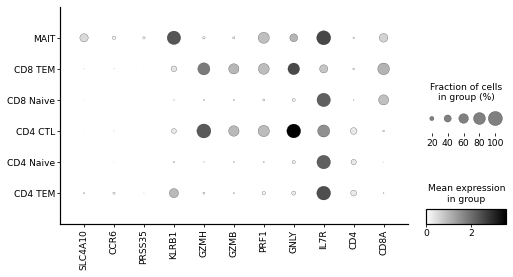

In [70]:
include = ["MAIT", "CD8 TEM", "CD8 Naive", "CD4 CTL", "CD4 Naive", "CD4 TEM"]
include_mask = [c in include for c in query_dot.obs.predicted_l2_scarches]

fig = sc.pl.dotplot(
    query_dot[include_mask],
    groupby="predicted_l2_scarches",
    var_names=["SLC4A10", "CCR6", "PRSS35", "KLRB1"] + ["GZMH", "GZMB", "PRF1", "GNLY"] + ["IL7R", "CD4", "CD8A"],
    categories_order=include,
    cmap="binary",
    figsize=(8, 4),
    return_fig=True
#     dendrogram=True,
#     swap_axes=True,
)
fig.savefig("figs/dotplot.pdf", bbox_inches="tight")
plt.show()

/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/adam/.pyenv/versions/3.8.3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)
/home/adam/.pyenv/versions/scvi-tools-paper/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a f

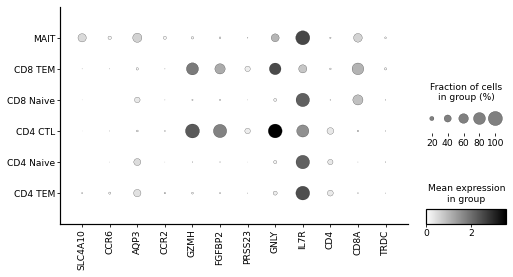

In [62]:
include = ["MAIT", "CD8 TEM", "CD8 Naive", "CD4 CTL", "CD4 Naive", "CD4 TEM"]
include_mask = [c in include for c in query_dot.obs.predicted_l2_scarches]

sc.pl.dotplot(
    query_dot[include_mask],
    groupby="predicted_l2_scarches",
    var_names=mait_df.index[:4].to_list() + cd4_ctl_df.index[:4].to_list() + ["IL7R", "CD4", "CD8A", "TRDC"],
    categories_order=include,
    cmap="binary",
    figsize=(8, 4),
#     dendrogram=True,
#     swap_axes=True,
)
